# Cómo se gana un Tour — EDA (1980+)


**Meta:** entender la dinámica del Tour de France para guiar estrategia/entrenamiento.
- ¿Cuándo toma el líder el control?
- ¿En qué tipos de etapa (montaña/llano/CR) se abren más diferencias?
- ¿Cómo cambia la dificultad general (starters/finishers)?


In [37]:
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata

plt.rcParams["figure.figsize"] = (10,5)
pd.set_option("display.max_columns", 50)

DATA_DIR   = r"./data/TourDeFrance19032022"
START_YEAR = 1980

STAGES_CSV    = os.path.join(DATA_DIR, "tdf_stages.csv")
WINNERS_CSV   = os.path.join(DATA_DIR, "tdf_winners.csv")
TOURS_CSV     = os.path.join(DATA_DIR, "tdf_tours.csv")
FINISHERS_CSV = os.path.join(DATA_DIR, "tdf_finishers.csv")

## 1) Cargar y normalizar datos

In [38]:
def read_csv_smart(path):
    try:
        return pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="latin1")

def normalize_cols(df):
    df.columns = (df.columns.str.strip()
                  .str.replace(r"\s+","_", regex=True)
                  .str.replace(r"[^0-9a-zA-Z_]", "", regex=True))
    return df

stages    = normalize_cols(read_csv_smart(STAGES_CSV))
winners   = normalize_cols(read_csv_smart(WINNERS_CSV))
tours     = normalize_cols(read_csv_smart(TOURS_CSV))
finishers = normalize_cols(read_csv_smart(FINISHERS_CSV))

for df in (stages, winners, tours, finishers):
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")

stages    = stages[stages["Year"]    >= START_YEAR].copy()
winners   = winners[winners["Year"]   >= START_YEAR].copy()
tours     = tours[tours["Year"]      >= START_YEAR].copy()
finishers = finishers[finishers["Year"]>= START_YEAR].copy()

print("shapes:", stages.shape, winners.shape, tours.shape, finishers.shape)
stages.head(3)
tours

shapes: (940, 7) (36, 13) (43, 6) (6059, 5)


,Year,Dates,Stages,Distance,Starters,Finishers
66,1980,26 June  20 July 1980,"22 + Prologue, including two split stages","3,842 km (2,387 mi)",130,85
67,1981,25 June  19 July 1981,"22 + Prologue, including two split stages","3,753 km (2,332 mi)",150,121
68,1982,225 July 1982,"21 + Prologue, including one split stage","3,507 km (2,179 mi)",169,125
69,1983,124 July 1983,22 + Prologue,"3,809 km (2,367 mi)",140,88
70,1984,29 June  22 July 1984,23 + Prologue,"4,021 km (2,499 mi)",170,124
71,1985,28 June  21 July 1985,"22 + Prologue, including one split stage","4,109 km (2,553 mi)",180,144
72,1986,427 July 1986,23 + Prologue,"4,094 km (2,544 mi)",210,132
73,1987,126 July 1987,25 + Prologue,"4,231 km (2,629 mi)",207,135
74,1988,224 July 1988,22 + Prologue,"3,286 km (2,042 mi)",198,151
75,1989,123 July 1989,21 + Prologue,"3,285 km (2,041 mi)",198,138


## 2) Limpiezas clave y features
- Distancias a km
- Tipos de etapa normalizados
- N° de etapa como entero (a/b -> mismo día)
- Tiempos y márgenes a segundos

In [39]:
def parse_distance_km_smart(x):
    """
    Soporta:
      - '3,842 km (2,387 mi)'  -> 3842.0   (coma = miles)
      - '188,5 km'             -> 188.5    (coma = decimal)
      - '3,412.5 km'           -> 3412.5   (mixto , y .)
      - '4 822 km' / '4 822 km'-> 4822.0   (espacios finos)
    """
    if pd.isna(x): return np.nan
    s = str(x)

    # Normaliza y limpia espacios raros
    s = unicodedata.normalize("NFKC", s)
    s = (s.replace("\xa0"," ")
           .replace("\u202f"," ")
           .replace("\u2009"," ")
           .strip())

    m = re.search(r"([0-9][0-9\.,\s]*)\s*km", s, flags=re.IGNORECASE)
    if not m: 
        return np.nan

    num = m.group(1)
    num = re.sub(r"\s+", "", num)  # quita espacios dentro del número

    # Caso mixto: tiene punto y coma -> coma como miles
    if "." in num and "," in num:
        num = num.replace(",", "")  # ej. '3,412.5' -> '3412.5'

    # Solo comas (hay que decidir miles vs decimal)
    elif "," in num and "." not in num:
        parts = num.split(",")
        # Si el bloque final tiene 3 dígitos (y los intermedios también 3), tratamos comas como miles
        if all(len(p)==3 for p in parts[1:]):
            num = "".join(parts)     # '3,842' -> '3842'
        else:
            num = ".".join(parts)    # '188,5' -> '188.5'

    # Solo puntos -> ya está

    # Limpieza final
    num = re.sub(r"[^0-9.]", "", num)
    try:
        return float(num)
    except:
        return np.nan

def normalize_stage_type(raw):
    if pd.isna(raw): return raw
    t = str(raw).strip().lower()
    if "team time trial" in t: return "TTT"
    if "time trial" in t:     return "ITT"
    if "prologue" in t:       return "Prologue"
    if "mountain" in t:       return "Mountain"
    if "hilly" in t:          return "Hilly"
    if "plain" in t or "flat" in t: return "Flat"
    return raw

def to_int_stage(x):
    #"12a" y "12b" -> 12 (día de carrera)
    try: return int(re.sub(r"[^\d]","", str(x)))
    except: return np.nan

def parse_hms_to_seconds(s):
    if pd.isna(s): return np.nan
    s = (str(s).replace("\xa0"," ").replace("″","''").replace("’","'").replace("‘","'")
                .lstrip("+ ").strip())
    m = re.search(r"(?P<h>\d+)\s*h\s*(?P<m>\d+)\s*['′]\s*(?P<sec>\d+)", s)
    if m: return int(m.group("h"))*3600 + int(m.group("m"))*60 + int(m.group("sec"))
    m2 = re.search(r"(?P<m>\d+)\s*['′]\s*(?P<sec>\d+)$", s)
    if m2: return int(m2.group("m"))*60 + int(m2.group("sec"))
    m3 = re.search(r"(?P<sec>\d+)\s*['\"]{1,2}$", s)
    if m3: return int(m3.group("sec"))
    m4 = re.search(r"(?P<h>\d+):(?P<m>\d+):(?P<sec>\d+)$", s)
    if m4:
        h, mi, se = map(int, [m4.group("h"), m4.group("m"), m4.group("sec")])
        return h*3600 + mi*60 + se
    return np.nan

#Tours
if "Distance" in tours.columns:
    tours["Distance_km"] = tours["Distance"].apply(parse_distance_km_smart)
if "Stages" in tours.columns:
    tours["Total_Stages"] = (tours["Stages"].astype(str)
                             .str.replace("\xa0"," ", regex=False)
                             .str.extract(r"(\d+)", expand=False).astype(float))
for c in ("Starters","Finishers"):
    if c in tours.columns:
        tours[c] = pd.to_numeric(tours[c], errors="coerce")
if {"Starters","Finishers"}.issubset(tours.columns):
    tours["Attrition_rate"] = (tours["Starters"] - tours["Finishers"]) / tours["Starters"]

#Winners
if "Stages Won" in winners.columns:
    winners["Stages_Won"] = pd.to_numeric(winners["Stages Won"], errors="coerce")
if "Stages Led" in winners.columns:
    winners["Stages_Led"] = pd.to_numeric(winners["Stages Led"], errors="coerce")
if "Avg Speed" in winners.columns:
    winners["Avg_Speed"] = (winners["Avg Speed"].astype(str)
                            .str.replace("\xa0"," ", regex=False)
                            .str.replace("km/h","", regex=False)
                            .str.replace(",",".")
                            .str.extract(r"([\d\.]+)", expand=False).astype(float))
if "Margin" in winners.columns:
    winners["Margin_seconds"] = winners["Margin"].apply(parse_hms_to_seconds)

#Stages
stages["Type_norm"] = stages["Type"].apply(normalize_stage_type)
stages["Stage_num"] = stages["Stage"].apply(to_int_stage)
stages["Distance_km"] = stages["Distance"].apply(parse_distance_km_smart)

#Finishers
#Eliminar filas con Rank no numérico (DSQ, DNF, DNS, etc.)
finishers = finishers[pd.to_numeric(finishers["Rank"], errors="coerce").notna()]

#Convertir Rank a entero
finishers["Rank"] = finishers["Rank"].astype(int)

def compute_total_time_seconds(group: pd.DataFrame) -> pd.DataFrame:
    g = group.copy()
    base = parse_hms_to_seconds(g.loc[g["Rank"]==1, "Time"].iloc[0]) if (g["Rank"]==1).any() else np.nan
    def _row(row):
        txt = str(row["Time"])
        if row["Rank"] == 1:
            return parse_hms_to_seconds(txt)
        if txt.strip().startswith("+"):
            margin = parse_hms_to_seconds(txt)
            return base + margin if pd.notna(base) and pd.notna(margin) else np.nan
        return parse_hms_to_seconds(txt)
    g["total_time_seconds"] = g.apply(_row, axis=1)
    g["gap_to_winner_seconds"] = g["total_time_seconds"] - g["total_time_seconds"].min()
    return g

finishers_clean = finishers.groupby("Year", group_keys=False).apply(compute_total_time_seconds)

print(winners[["Year","Rider","Stages_Led","Stages_Won","Margin_seconds"]].head(3))
print(tours[["Year","Total_Stages","Distance_km","Starters","Finishers","Attrition_rate"]].head(3))
print(stages[["Year","Stage","Stage_num","Type","Type_norm","Distance_km"]].head(3))
print(finishers_clean[["Year","Rank","Rider","total_time_seconds","gap_to_winner_seconds"]].head(3))

    Year            Rider  Stages_Led  Stages_Won  Margin_seconds
66  1980   Joop Zoetemelk        10.0           2              55
67  1981  Bernard Hinault        18.0           5              34
68  1982  Bernard Hinault        12.0           4              21
    Year  Total_Stages  Distance_km  Starters  Finishers  Attrition_rate
66  1980          22.0       3842.0       130         85        0.346154
67  1981          22.0       3753.0       150        121        0.193333
68  1982          21.0       3507.0       169        125        0.260355
      Year Stage  Stage_num                   Type Type_norm  Distance_km
1401  1980     P        NaN  Individual time trial       ITT          8.0
1402  1980    1a        1.0            Plain stage      Flat        133.0
1403  1980    1b        1.0        Team time trial       TTT         46.0
      Year  Rank                 Rider  total_time_seconds  \
3836  1980     1  Joop Zoetemelk (NED)            393554.0   
3837  1980     2   Henni

C:\Users\daher\AppData\Local\Temp\ipykernel_11640\1396734671.py:134: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  finishers_clean = finishers.groupby("Year", group_keys=False).apply(compute_total_time_seconds)


## 3) Visión general

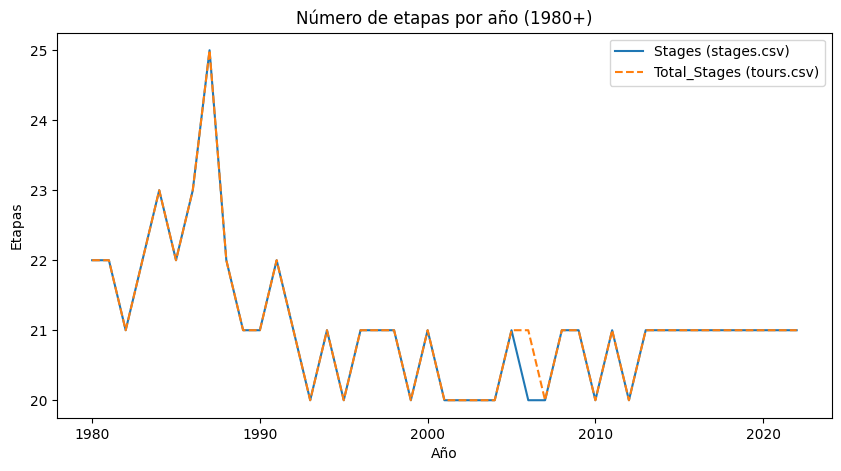

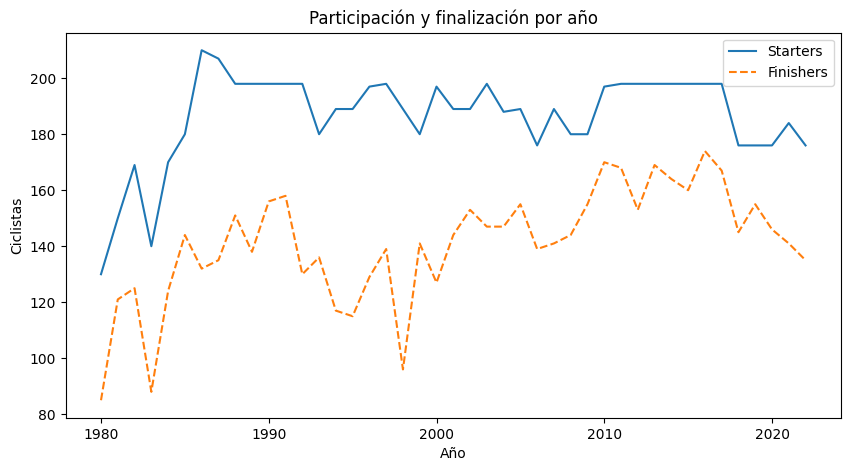

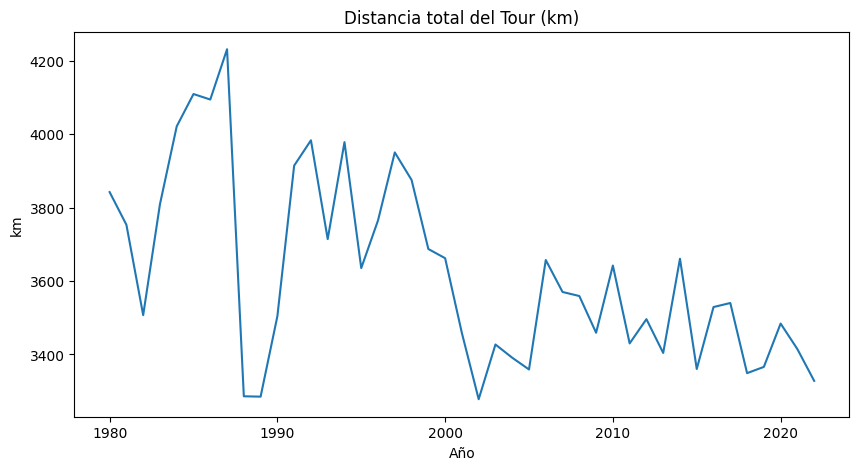

In [40]:
#3.1 Número de etapas por año (según 'tours') vs conteo en stages (únicos Stage_num)
stages_count = stages.groupby("Year")["Stage_num"].nunique().reset_index(name="stages_count")
stages_check = tours.merge(stages_count, on="Year", how="left")

fig, ax = plt.subplots()
ax.plot(stages_check["Year"], stages_check["stages_count"], label="Stages (stages.csv)")
if "Total_Stages" in stages_check.columns and stages_check["Total_Stages"].notna().any():
    ax.plot(stages_check["Year"], stages_check["Total_Stages"], linestyle="--", label="Total_Stages (tours.csv)")
ax.set_title("Número de etapas por año (1980+)")
ax.set_xlabel("Año"); ax.set_ylabel("Etapas")
ax.legend(); plt.show()

#3.2 Starters vs Finishers (¿quiénes terminan?)
if {"Starters","Finishers"}.issubset(tours.columns):
    fig, ax = plt.subplots()
    ax.plot(tours["Year"], tours["Starters"], label="Starters")
    ax.plot(tours["Year"], tours["Finishers"], label="Finishers", linestyle="--")
    ax.set_title("Participación y finalización por año")
    ax.set_xlabel("Año"); ax.set_ylabel("Ciclistas")
    ax.legend(); plt.show()

#3.3 Distancia total del Tour (si existe)
if "Distance_km" in tours.columns:
    fig, ax = plt.subplots()
    ax.plot(tours["Year"], tours["Distance_km"])
    ax.set_title("Distancia total del Tour (km)")
    ax.set_xlabel("Año"); ax.set_ylabel("km")
    plt.show()

#### Número de etapas por año (1980+)
La gráfica muestra que, desde 1980, el número de etapas del Tour de Francia ha tenido ligeras variaciones, con un pico en 1988 (25 etapas) y una tendencia a estabilizarse en torno a las 21 etapas desde principios de los 2000. Esto refleja que, aunque ha habido ajustes históricos, en las últimas décadas se ha mantenido un formato bastante constante.

#### Participación y finalización por año
Se observa que el número de ciclistas que inician (Starters) es siempre mayor que el de quienes logran finalizar (Finishers), lo cual es esperable debido a abandonos por lesiones, fatiga o descalificaciones. Sin embargo, la brecha entre ambos ha variado con los años: en los 80 y 90 hubo años con mayor abandono, mientras que en la última década la diferencia se ha reducido, lo que podría indicar mejores condiciones, preparación o estrategias.

#### Distancia total del Tour (km)
La distancia total ha mostrado cambios significativos a lo largo del tiempo, con valores máximos por encima de los 4,200 km en los 80 y caídas importantes a finales de los 80 y principios de los 2000. En las últimas dos décadas, la distancia tiende a ser menor (alrededor de 3,300 a 3,500 km), lo que podría estar relacionado con cambios en el diseño del recorrido para hacerlo más explosivo y televisivamente atractivo, sin sacrificar el espectáculo.

## 4) Estructura del Tour (tipos de etapa) y dificultad
- ¿Qué tipos de etapa hay cada año?
- ¿Cómo se reparte (proporciones)?
- ¿Las carreras son más "apretadas" o se abren diferencias grandes?

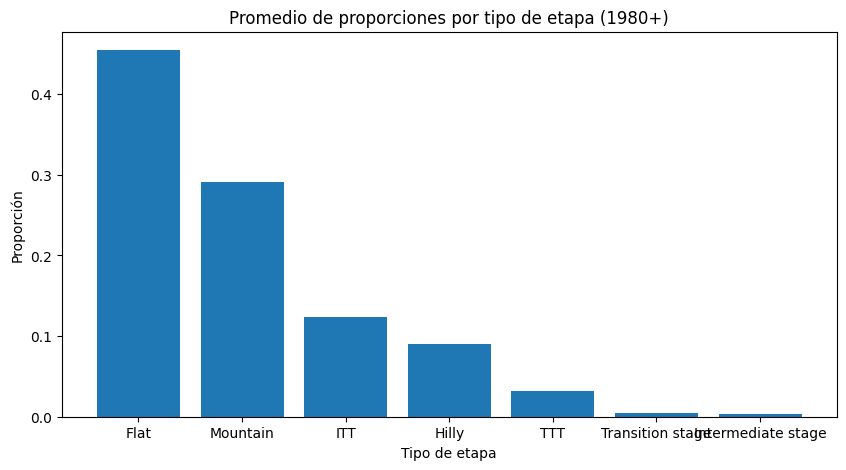

C:\Users\daher\AppData\Local\Temp\ipykernel_11640\871914634.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby("Year").apply(year_spreads).reset_index()


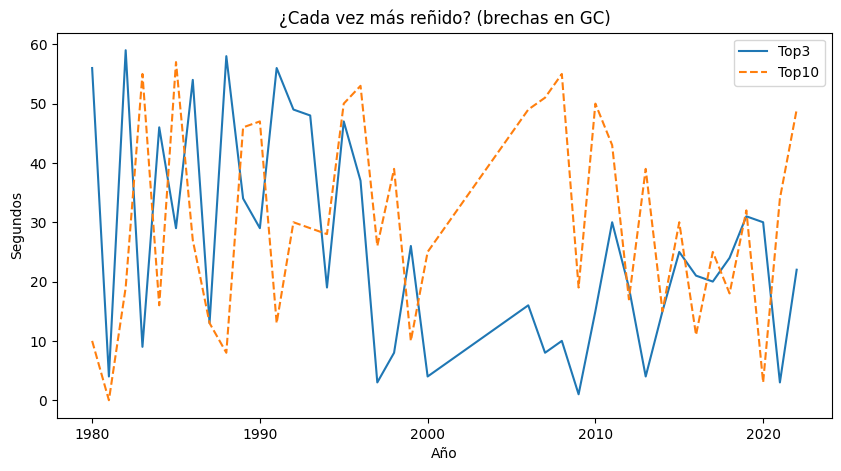


Conteo de ciclistas por año:
    Year  Rank
0   1980    85
1   1981   121
2   1982   125
3   1983    88
4   1984   124
5   1985   144
6   1986   132
7   1987   135
8   1988   151
9   1989   138
10  1990   156
11  1991   158
12  1992   130
13  1993   136
14  1994   117
15  1995   115
16  1996   129
17  1997   139
18  1998    96
19  1999   141
20  2000   127
21  2001   143
22  2002   151
23  2003   146
24  2004   143
25  2005   150
26  2006   134
27  2007   139
28  2008   143
29  2009   151
30  2010   165
31  2011   166
32  2012   152
33  2013   169
34  2014   164
35  2015   160
36  2016   174
37  2017   167
38  2018   145
39  2019   155
40  2020   146
41  2021   141
42  2022   134


In [41]:
#4.1 Conteo por tipo y shares
type_count = stages.groupby(["Year","Type_norm"]).size().unstack(fill_value=0).reset_index()
type_cols = [c for c in type_count.columns if c != "Year"]
type_count["total"] = type_count[type_cols].sum(axis=1)
for c in type_cols:
    type_count[f"share_{c}"] = type_count[c] / type_count["total"]

#Gráfico: promedio de shares en 1980+
share_cols = [c for c in type_count.columns if c.startswith("share_")]
mean_shares = type_count[share_cols].mean().sort_values(ascending=False)
fig, ax = plt.subplots()
ax.bar(mean_shares.index.str.replace("share_",""), mean_shares.values)
ax.set_title("Promedio de proporciones por tipo de etapa (1980+)")
ax.set_xlabel("Tipo de etapa"); ax.set_ylabel("Proporción")
plt.show()

#4.2 "Qué tan apretado": spreads entre Top3/Top10 en la general
def year_spreads(group):
    g = group.sort_values("Rank")
    s1  = g["total_time_seconds"].iloc[0] if len(g)>=1  else np.nan
    s3  = g["total_time_seconds"].iloc[2] if len(g)>=3  else np.nan
    s10 = g["total_time_seconds"].iloc[9] if len(g)>=10 else np.nan
    return pd.Series({
        "spread_top3_sec":  s3 - s1 if pd.notna(s1) and pd.notna(s3) else np.nan,
        "spread_top10_sec": s10 - s1 if pd.notna(s1) and pd.notna(s10) else np.nan
    })
spreads_by_year = finishers_clean.dropna(subset=["total_time_seconds"]) \
                                 .groupby("Year").apply(year_spreads).reset_index()

fig, ax = plt.subplots()
ax.plot(spreads_by_year["Year"], spreads_by_year["spread_top3_sec"], label="Top3")
ax.plot(spreads_by_year["Year"], spreads_by_year["spread_top10_sec"], label="Top10", linestyle="--")
ax.set_title("¿Cada vez más reñido? (brechas en GC)")
ax.set_xlabel("Año"); ax.set_ylabel("Segundos")
ax.legend(); plt.show()


#También ver cuántos hay en total por año
conteo_por_año = finishers_clean.groupby("Year")["Rank"].count().reset_index()
print("\nConteo de ciclistas por año:")
print(conteo_por_año)

#### Promedio de proporciones por tipo de etapa (1980+)
Desde 1980, el Tour de Francia ha mantenido una estructura en la que predominan las etapas planas, que representan casi la mitad del total, seguidas por las etapas de montaña, que constituyen cerca de un tercio. Las contrarrelojes individuales y las etapas quebradas tienen un papel secundario, mientras que las contrarrelojes por equipos y las etapas de transición o intermedias son muy poco frecuentes. Esto revela un diseño enfocado en jornadas llanas y de montaña como ejes principales de la competencia.

#### ¿Cada vez más reñido? (brechas en la clasificación general)
El análisis de las diferencias de tiempo entre el primer puesto y el tercero (Top3), así como entre el primero y el décimo (Top10), muestra que en las últimas décadas las brechas entre los tres primeros se han reducido considerablemente respecto a los años 80 y 90, indicando mayor paridad en la lucha por el podio. Sin embargo, las diferencias con el décimo lugar siguen siendo más amplias y variables, lo que sugiere que, aunque el grupo líder está más ajustado, aún existe un salto notable hacia los puestos más bajos de la élite.

## 6) Control del maillot amarillo (simplificado)
Usamos 'Stages Led' del ganador (Winners) y lo comparamos con el total de etapas.

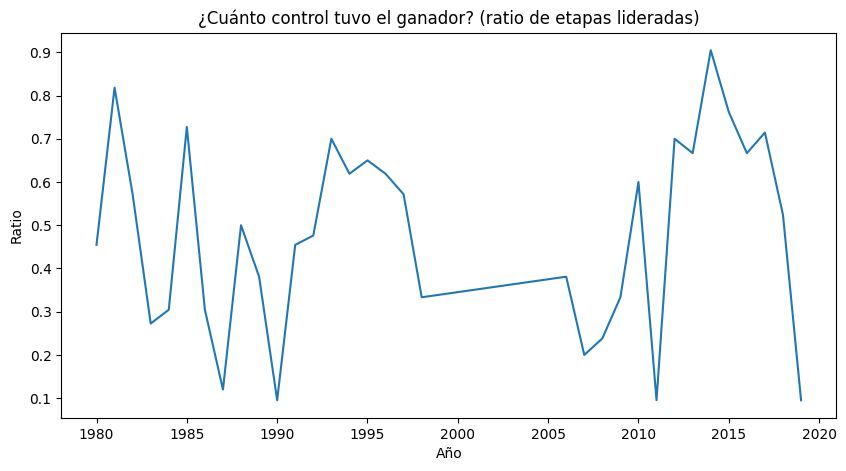

,Year,Rider,Stages_Led,Total_Stages,Stages_Led_ratio,Dominio_timing
0,1980,Joop Zoetemelk,10.0,22.0,0.454545,Medio
1,1981,Bernard Hinault,18.0,22.0,0.818182,Temprano
2,1982,Bernard Hinault,12.0,21.0,0.571429,Medio
3,1983,Laurent Fignon,6.0,22.0,0.272727,Tarde
4,1984,Laurent Fignon,7.0,23.0,0.304348,Medio
5,1985,Bernard Hinault,16.0,22.0,0.727273,Temprano
6,1986,Greg LeMond,7.0,23.0,0.304348,Medio
7,1987,Stephen Roche,3.0,25.0,0.120000,Tarde
8,1988,Pedro Delgado,11.0,22.0,0.500000,Medio
9,1989,Greg LeMond,8.0,21.0,0.380952,Medio


In [42]:
control = winners.merge(tours[["Year","Total_Stages"]], on="Year", how="left")
control["Stages_Led_ratio"] = control["Stages_Led"] / control["Total_Stages"]
#Clasificación simple para comunicar "temprano / medio / tarde"
control["Dominio_timing"] = pd.cut(control["Stages_Led_ratio"],
                                   bins=[0,0.3,0.7,1.01],
                                   labels=["Tarde","Medio","Temprano"],
                                   include_lowest=True)

fig, ax = plt.subplots()
ax.plot(control["Year"], control["Stages_Led_ratio"])
ax.set_title("¿Cuánto control tuvo el ganador? (ratio de etapas lideradas)")
ax.set_xlabel("Año"); ax.set_ylabel("Ratio")
plt.show()

control[["Year","Rider","Stages_Led","Total_Stages","Stages_Led_ratio","Dominio_timing"]].head(10)

En la gráfica se muestra el ratio de etapas lideradas por el ganador, se observa que el control del líder sobre la carrera ha variado significativamente a lo largo de los años. Hay periodos donde el ganador dominó una gran parte de las etapas (valores cercanos a 0.8 o más), indicando una clara superioridad, y otros donde el control fue mucho menor (valores cercanos a 0.1), reflejando carreras más abiertas y disputadas.

## 7) Dificultad del día a día (abandono macro)
Sin datos de abandonos por etapa, miramos tasa de abandono del Tour completo.

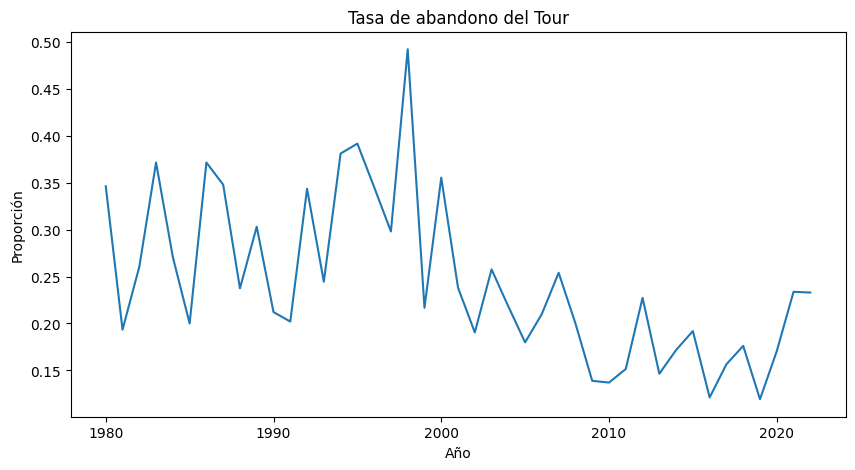

In [43]:
if {"Starters","Finishers","Attrition_rate"}.issubset(tours.columns):
    fig, ax = plt.subplots()
    ax.plot(tours["Year"], tours["Attrition_rate"])
    ax.set_title("Tasa de abandono del Tour")
    ax.set_xlabel("Año"); ax.set_ylabel("Proporción")
    plt.show()

    tours[["Year","Starters","Finishers","Attrition_rate"]].tail(10)
else:
    print("No hay 'Starters' y 'Finishers' completos en 'tours' para tasa de abandono.")

En la tasa de abandono del Tour, se aprecia que a finales de los 90 hubo un aumento considerable en el porcentaje de ciclistas que no finalizaron la competencia, llegando a rozar el 50%. Sin embargo, en las últimas dos décadas la tendencia general ha sido a la baja, con proporciones menores al 20% en varios años, lo que sugiere mejoras en preparación física, estrategias de equipo y posiblemente en las condiciones de la carrera.

### 4) Control del maillot amarillo
Comparamos `Stages_Led` del ganador con el total de etapas del año para estimar si dominó pronto o tarde.

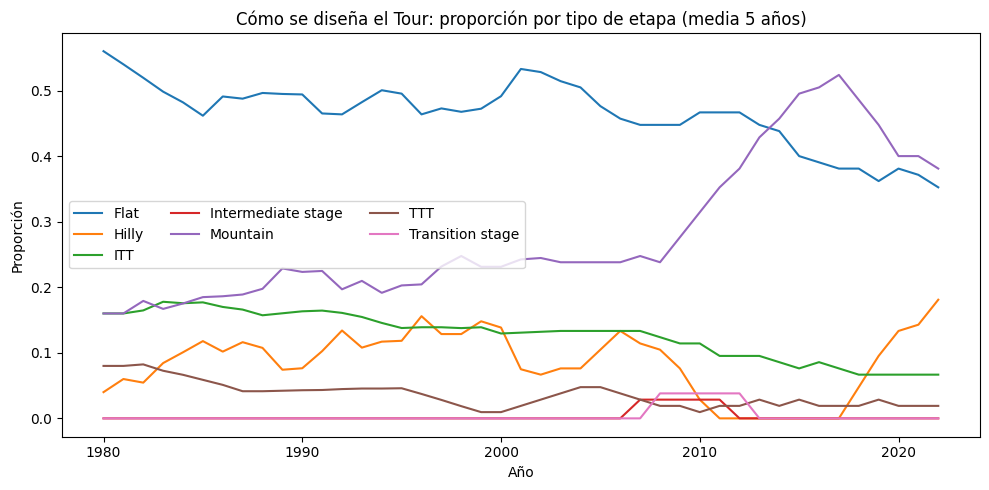

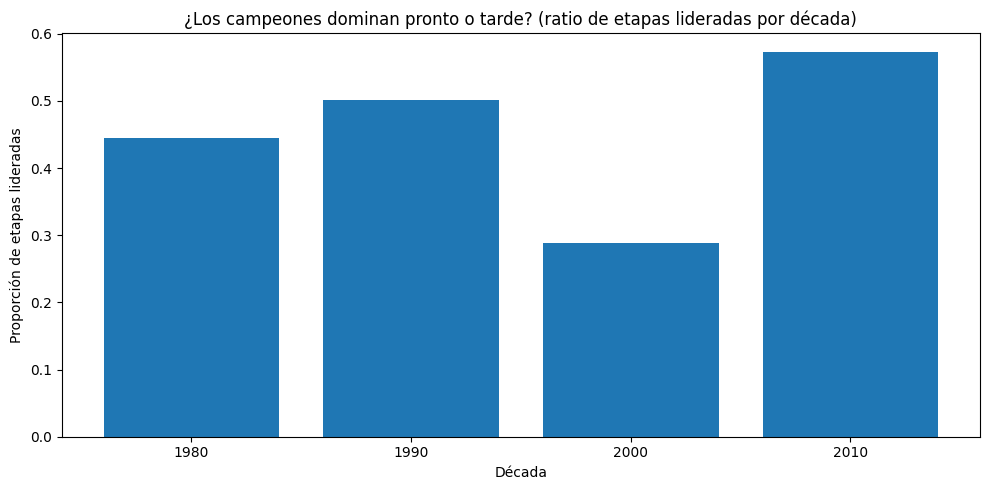

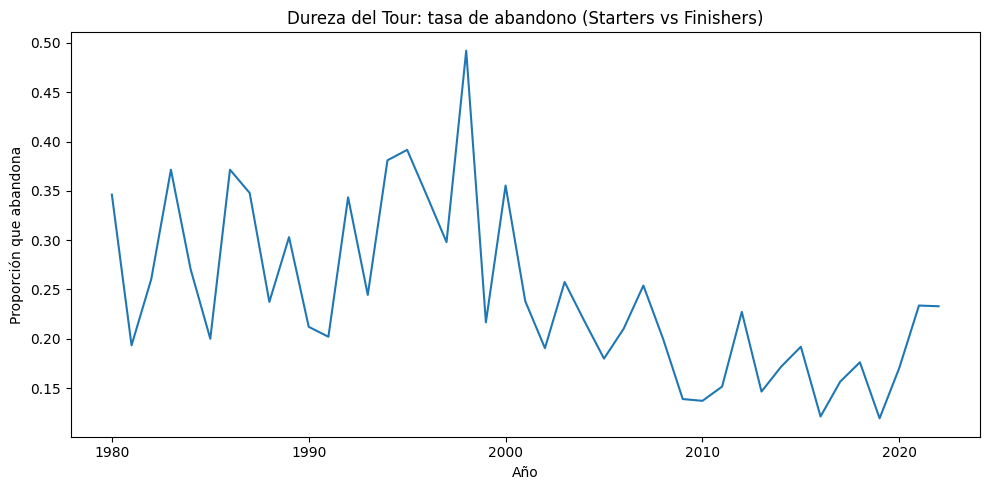


Top 10 años más duros por tasa de abandono:
 Year  Attrition_rate  Starters  Finishers
 1998        0.492063       189         96
 1995        0.391534       189        115
 1994        0.380952       189        117
 1983        0.371429       140         88
 1986        0.371429       210        132
 2000        0.355330       197        127
 1987        0.347826       207        135
 1980        0.346154       130         85
 1996        0.345178       197        129
 1992        0.343434       198        130


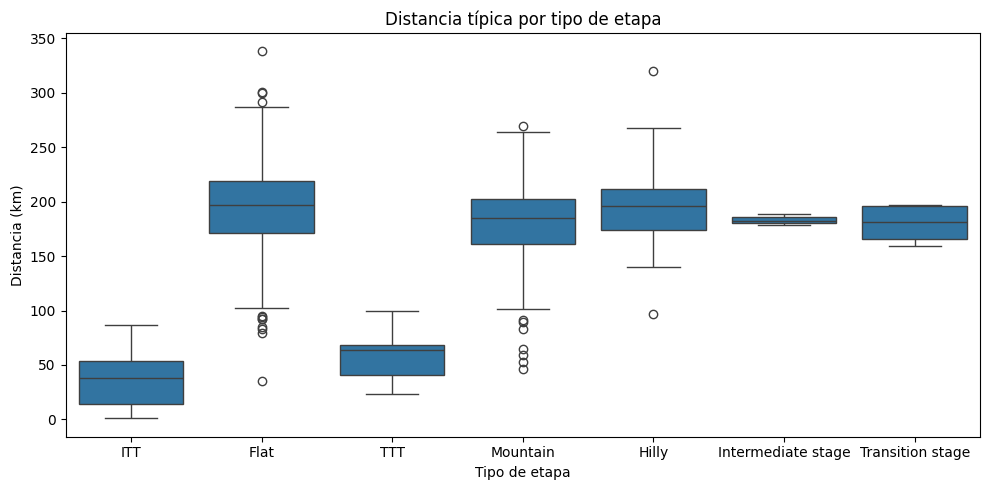

In [44]:
# (A) Evolución de la estructura del Tour: % por tipo (promedios móviles de 5 años para suavizar)
type_count = stages.groupby(["Year","Type_norm"]).size().unstack(fill_value=0).reset_index()
type_cols = [c for c in type_count.columns if c != "Year"]
type_count["total"] = type_count[type_cols].sum(axis=1)
for c in type_cols:
    type_count[f"share_{c}"] = type_count[c] / type_count["total"]

share_cols = [c for c in type_count.columns if c.startswith("share_")]
type_share = type_count[["Year"]+share_cols].sort_values("Year").copy()
for c in share_cols:
    type_share[c] = type_share[c].rolling(window=5, min_periods=1).mean()

fig, ax = plt.subplots()
for c in share_cols:
    ax.plot(type_share["Year"], type_share[c], label=c.replace("share_",""))
ax.set_title("Cómo se diseña el Tour: proporción por tipo de etapa (media 5 años)")
ax.set_xlabel("Año"); ax.set_ylabel("Proporción")
ax.legend(ncol=3)
plt.tight_layout(); plt.show()

# (B) Control del maillot del campeón (barras claras)
control = winners.merge(tours[["Year","Total_Stages"]], on="Year", how="left")
control["Stages_Led_ratio"] = control["Stages_Led"] / control["Total_Stages"]
# Promedio por década para hacerlo fácil de leer
control["Decade"] = (control["Year"] // 10) * 10
mean_led = control.groupby("Decade")["Stages_Led_ratio"].mean().reset_index()

fig, ax = plt.subplots()
ax.bar(mean_led["Decade"].astype(str), mean_led["Stages_Led_ratio"])
ax.set_title("¿Los campeones dominan pronto o tarde? (ratio de etapas lideradas por década)")
ax.set_xlabel("Década"); ax.set_ylabel("Proporción de etapas lideradas")
plt.tight_layout(); plt.show()

# (C) Dureza global: tasa de abandono (Starters vs Finishers)
if {"Starters","Finishers","Attrition_rate"}.issubset(tours.columns):
    tours_sorted = tours.sort_values("Year")
    fig, ax = plt.subplots()
    ax.plot(tours_sorted["Year"], tours_sorted["Attrition_rate"])
    ax.set_title("Dureza del Tour: tasa de abandono (Starters vs Finishers)")
    ax.set_xlabel("Año"); ax.set_ylabel("Proporción que abandona")
    plt.tight_layout(); plt.show()

    # Top 10 años más duros (tabla simple)
    top_hard = tours_sorted.nlargest(10, "Attrition_rate")[["Year","Attrition_rate","Starters","Finishers"]]
    print("\nTop 10 años más duros por tasa de abandono:")
    print(top_hard.to_string(index=False))

fig, ax = plt.subplots()
sns.boxplot(data=stages, x="Type_norm", y="Distance_km", ax=ax)
ax.set_title("Distancia típica por tipo de etapa")
ax.set_xlabel("Tipo de etapa"); ax.set_ylabel("Distancia (km)")
plt.tight_layout(); plt.show()


#### Proporción por tipo de etapa (media 5 años)
El diseño del Tour ha cambiado con el tiempo, reduciendo gradualmente la proporción de etapas planas y aumentando la presencia de etapas de montaña, especialmente desde mediados de los 2000. Las etapas contrarreloj individual (ITT) han disminuido, mientras que las etapas de media montaña (Hilly) han tenido un incremento notable en la última década, lo que sugiere un enfoque hacia recorridos más variados y exigentes.

#### Ratio de etapas lideradas por década
El análisis por décadas muestra que los campeones han tenido un control creciente sobre el liderato de etapas, alcanzando su punto más alto en la década de 2010. Esto indica que en los últimos años los ganadores tienden a consolidar su dominio más rápido y de manera más consistente a lo largo de la carrera.

#### Tasa de abandono del Tour (Starters vs Finishers)
La tasa de abandono ha mostrado una tendencia decreciente desde finales de los 90, lo que podría reflejar mejoras en preparación física, soporte médico y estrategias de equipo. Sin embargo, algunos picos aislados, como en 1998, evidencian ediciones particularmente exigentes.

#### Top 10 años más duros por tasa de abandono
Entre los años más duros destacan 1998, 1995 y 1994, con tasas de abandono superiores al 38%. Estos años no solo tuvieron recorridos exigentes, sino que también estuvieron marcados por factores externos como condiciones climáticas adversas y posibles controversias en torno a dopaje y regulaciones, que incrementaron el desgaste y las retiradas.

#### Distancia típica por tipo de etapa
Las etapas planas y de montaña presentan las distancias más largas, superando en muchos casos los 200 km, mientras que las contrarrelojes, tanto individuales como por equipos, se mantienen considerablemente más cortas. Las etapas intermedias y de transición muestran poca variación de distancia, concentrándose alrededor de los 180-190 km.